In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats import multitest
from matplotlib.backends.backend_pdf import PdfPages
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

from Modules import plot_ax_violin
from Modules import read_data
from Modules import sholl_analysis

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5

In [2]:
def read_lin_data():
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/Lab_Pvalb-tpm.tsv'
    df = pd.read_csv(fname, **kwargs)
    
    fname = 'Datasets/Lab_Pvalb-transcriptional_labels.tsv'
    df_labels = pd.read_csv(fname, **kwargs)
    df_labels = df_labels.loc[df_labels.index.isin(df.columns)]
    df_labels.sort_values('Age', inplace=True)
    df = np.log2(1+df.loc[:,df_labels.index])
    
    return df, df_labels

def get_family_data(df, family):
    fname = '/home/soma/Documents/Newest/analysisfiles/%smouse.txt' % family
    with open(fname) as f:
        genes = [line.split()[0] for line in f]
    
    df = df.loc[df.index.isin(genes)]
    
    return df

def get_ion_data():
    df_lin, df_labels = read_lin_data()
    is_bc = df_labels['Morph-PV-types'] == 'vBC'
    df= df_lin.loc[:,is_bc].copy()
    df.columns = df_labels.Age[is_bc]
    df = df.loc[(df.values>1).sum(axis=1)>5].copy()
    columns = np.array(['<P21'] * df.shape[1])
    columns[df.columns>21] = '>P21'
    arrays = (columns, df.columns)
    df.columns = pd.MultiIndex.from_arrays(arrays, names=('Category', 'Age'))
        
    df_volt = get_family_data(df, 'VOLTAGEGATED')
    df_lig = get_family_data(df, 'LIGANDGATED')
    
    return df_volt, df_lig

def get_ion_signif(df_ion):
    df_young = df_ion.xs('<P21', level='Category', axis=1)
    df_old = df_ion.xs('>P21', level='Category', axis=1)
    df_stat = pd.DataFrame(np.NaN, index=df_ion.index, columns=['Score', 'Pval'])
    for gene in df_stat.index:
        df_stat.loc[gene] = mannwhitneyu(df_young.loc[gene], df_old.loc[gene], alternative='two-sided')
    df_stat.Pval = df_stat.Pval
    df_stat.sort_values('Pval', inplace=True)
    df_stat['Padj'] = multitest.multipletests(df_stat.Pval.values, method='fdr_bh')[1]
    
    arrays = [['<P21'], ['>P21']]
    names = ('Category_1', 'Category_2')
    index = pd.MultiIndex.from_arrays(arrays, names=names)
    df_fdr = pd.DataFrame(np.NaN, index=index, columns=df_stat.index)
    df_fdr.iloc[0,:] = df_stat.Padj.values

    return df_stat, df_fdr

def create_family_plot(dfs, names, fig, axbg, top=0.90):
    df_merge = pd.concat(dfs, axis=0)
    df_stat, df_fdr = get_ion_signif(df_merge)

    fig.suptitle('Figure S9', fontsize=14, y=.93)
    
    celltypes = ('<P21', '>P21')
    df_marker = pd.read_csv('References/marker_ref.txt', sep='\t', header=0, index_col=0)
    kwargs = {'left':.10,
              'right':.9,
              'row_count':10,
              'rotation':45,
              'ticklabels':celltypes,
              'df_marker':df_marker,
              'show_violin':False, 
              'show_error':True,
              'show_box':False,
              'height':.040,
              'dh':.016,
              'labelsize':6,
              'ticksize':5,
              'dw':.03,
              'ylabel_coords':(-0.33, 0.5),
              'ticklabel_loc':'BOTTOM',
              'show_signif':True,
              'fdr_min':0.1
             }
    
    letters = 'de'
    
    for df, name, letter in zip(dfs, names, letters):
        df_key = df_stat.loc[df_stat.index.isin(df.index)]
        df_violin = df.loc[df_key.index].T
        df_violin.index = df_violin.index.get_level_values('Category')
        df_padj = df_fdr.loc[:,df_violin.columns]
        
        fig.text(.1, top, letter, fontsize=14, ha='left', va='top')
        fig.text(.5, top, name, fontsize=12, ha='center', va='top')
        kwargs['show_signif'] = df_padj
        args = (fig, top-.025, df_violin, celltypes)
        top = plot_ax_violin.plot_generated_electrophys(*args, **kwargs)
        top = top - .03
    
    return

def plot_age_depth(ax):
    df = pd.read_csv('References/Lab_Pvalb-sequence.tsv', sep='\t', header=0, index_col=0)
    df_labels = pd.read_csv('Datasets/Lab_Pvalb-labels.tsv', sep='\t', header=0, index_col=0)
    plt.scatter(df_labels.Age, np.log10(1e6*df['Aligned reads (M)']), color='blue', label='Aligned', s=1)
    plt.scatter(df_labels.Age, np.log10(1e6*df['Reads (M)']), color='red', label='Sequenced', s=1)
    
    ax.set_ylabel('Read number (log10)', fontsize=7)
    ax.set_xlabel('Age (days)', fontsize=7)
    
    ax.tick_params(size=1, labelsize=6)
    
    ax.legend(loc='upper right', fontsize=6)
    
    return

def evaluate_correlation(df_corr, ax_heat, cax_heat, ax_hist, top=25):
    same_min = df_corr.values[np.arange(df_corr.shape[0]),np.arange(df_corr.shape[0])].min()
    diff_max = np.triu(df_corr.values,k=1).max()
    
    pcol = ax_heat.pcolor(df_corr.values, vmin=0, vmax=1, cmap=cm.plasma)
    pcol.set_edgecolor('face')
    plt.colorbar(pcol, cax=cax_heat, orientation='vertical')
    ax_heat.tick_params(size=1, labelsize=6)
    cax_heat.tick_params(labelsize=6, size=1)
    
    diag = np.diag(df_corr.values)
    bins = np.linspace(0.90,1,6)
    ax_hist.hist(diag, bins=bins, color='blue', density=True, label='Self')
    upper = np.triu(df_corr.values, k=1)
    upper = upper[upper > 0]
    ax_hist.hist(upper, bins=15, color='red', density=True, label='Other')
    ax_hist.axis([0,1.02,0,top])
    ax_hist.set_xlabel('Pearson correlation coefficient', fontsize=7)
    ax_hist.tick_params(size=1, labelsize=6)
    ax_hist.set_ylabel('Frequency density\nnormalized counts', fontsize=7)
    
    ax_hist.legend(fontsize=6, loc='upper left')
    
    ax_heat.set_xlabel('Actual tpm values', fontsize=7)
    ax_heat.set_ylabel('Sub-sampled tpm values', fontsize=7)
    
    return

def get_tpm_comparison():
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    df_tpm = pd.read_csv('Datasets/Lab_Pvalb-tpm.tsv', **kwargs)
    df_labels = pd.read_csv('Datasets/Lab_Pvalb-labels.tsv', **kwargs)
    df_labels.sort_values('Age', inplace=True)
    df_tpm = df_tpm.loc[:,df_labels.index]
    df_norm = pd.read_csv('../Lin Paper Mod/Datasets/Lab_Pvalb-tpm.tsv', **kwargs)
    df_norm = df_norm[df_tpm.columns]
    
    keep = (df_tpm.values>0.2).mean(axis=1)>0.05
    
    df_tpm = np.log2(1+df_tpm.loc[keep])
    df_norm = np.log2(1+df_norm.loc[keep])
    
    df_pear = pd.DataFrame(np.NaN, index=df_tpm.columns, columns=df_tpm.columns)
    
    for index in df_tpm.columns:
        for column in df_norm.columns:
            df_pear.loc[index, column] = pearsonr(df_tpm[index].values, df_norm[column].values)[0]
    
    #Z = linkage(df_pear.values, method='average', metric='euclidean')
    #D = dendrogram(Z, no_plot=True)
    #inds = D['leaves']
    
    #df_pear = df_pear.iloc[inds,inds]
    
    return df_pear

def compare_tpm(fig):
    fig.text(.10, 0.90, 'a', fontsize=14, ha='left', va='top')
    fig.text(.40, 0.90, 'b', fontsize=14, ha='left', va='top')
    fig.text(.68, 0.90, 'c', fontsize=14, ha='left', va='top')
    df_pear = get_tpm_comparison()
    df_pear.index.name = 'Cell'
    df_pear.to_csv('Datasets/Lab_Pvalb-comparison.tsv', sep='\t')
    
    ax = fig.add_axes([.165, .75, .165, .1275])
    plot_age_depth(ax)
    
    ax_heat = fig.add_axes([.435, .75, .165, .1275])
    cax_heat = fig.add_axes([.605, .75, .01, .1275])
    ax_hist = fig.add_axes([.735, .75, .165, .1275])
    evaluate_correlation(df_pear, ax_heat, cax_heat, ax_hist, top=15)
    
    return

In [3]:
%%time

df_volt, df_lig = get_ion_data()

CPU times: user 349 ms, sys: 24.4 ms, total: 373 ms
Wall time: 372 ms


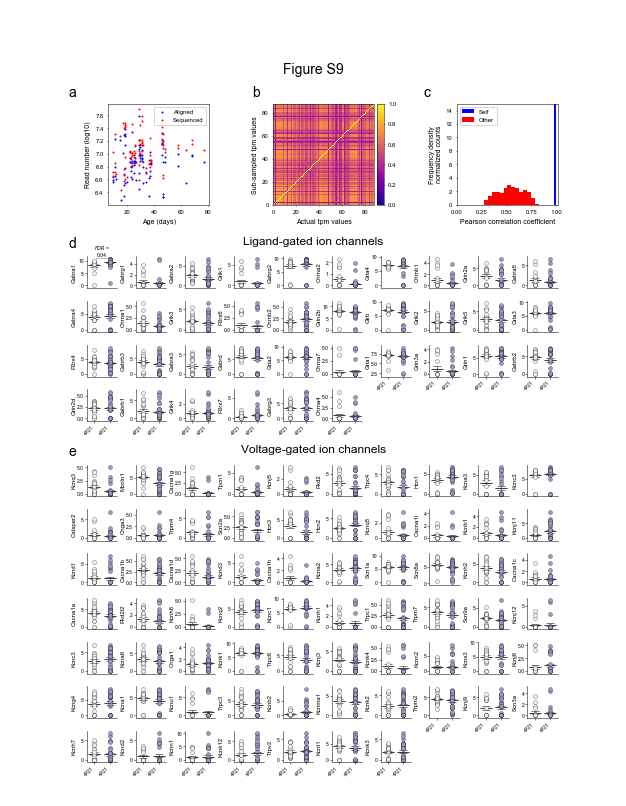

CPU times: user 1min 6s, sys: 59.9 s, total: 2min 5s
Wall time: 25.1 s


In [4]:
%%time

fig = plt.figure(figsize=(8.5,11))
axbg = fig.add_axes([0,0,1,1], frame_on=False)
axbg.set_xticks([]), axbg.set_yticks([]), axbg.axis([0,1,0,1])
dfs = [df_lig, df_volt]
names = ['Ligand-gated ion channels', 'Voltage-gated ion channels']
compare_tpm(fig)
create_family_plot(dfs, names, fig, axbg, top=0.71)

fig.savefig('Figures/Figure S9.pdf')
plt.show()
plt.close()

In [7]:
dfs[0].shape

(36, 50)

In [8]:
dfs[1].shape

(67, 50)

In [10]:
dfs[0].columns.get_level_values('Category').value_counts()

>P21    31
<P21    19
Name: Category, dtype: int64